# **ConvNet From Scratch with augmentations**

This will contain:
1. image augmentation for increasing the volume of input  
2. visualization of intermediate features and images
3. Fine-tuning the known architecture for the sake of learning

All will be coded in PyTorch




In [34]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [35]:
#Loading the datasets
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(
    root = 'data',
    train = True,
    download = True,
    transform = transform
)

test_dataset = datasets.CIFAR10(
    root = 'data',
    train = False,
    download = True,
    transform = transform
)

e:\Rijan_Shrestha\AI\AI Works\Paper-Reproduction\.venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


"Since we are using the concept of data augmentation, we will be using less samples of data. Currently, we have 5000 samples for cat and dogs each. But, we will use the dataset with 1000 training images, 500 validation imgages and 1000 test images"

In [36]:
from torch.utils.data import Subset
def create_balanced_subset(dataset, class_indices, start_index, end_index):

  targets = np.array(dataset.targets)
  selected_indices = []

  for cls in class_indices:
    indices = np.where(targets == cls)[0]
    selected_indices.extend(indices[start_index: end_index])

  dataset = Subset(dataset, selected_indices)
  return dataset

train_data = create_balanced_subset(train_dataset, [3,5], 0, 1000)
validation_data = create_balanced_subset(train_dataset, [3,5], 1000, 1500)
test_data = create_balanced_subset(test_dataset, [3,5], 0, 1000)

In [37]:
def check_subset_balance(subset, name="Subset"):
    # This pulls labels from the original dataset using the subset's internal indices
    labels = [subset.dataset.targets[i] for i in subset.indices]

    unique, counts = np.unique(labels, return_counts=True)
    print(f"--- {name} ---")
    print(f"Total samples: {len(subset)}")
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} samples")

check_subset_balance(train_data, "Training Set")
check_subset_balance(validation_data, "Validation Set")

--- Training Set ---
Total samples: 2000
Class 3: 1000 samples
Class 5: 1000 samples
--- Validation Set ---
Total samples: 1000
Class 3: 500 samples
Class 5: 500 samples


In [38]:
#Changing the class 3 -> 0 and 5 -> 1
class DatasetWrapper:
  def __init__(self, subset, mapping = {3 : 0, 5: 1}, transform = None):
    self.subset = subset
    self.mapping = mapping
    self.transform = transform

  def __getitem__(self, index):
    image, target = self.subset[index]
    if self.transform:
      image = self.transform(image)
    return image, self.mapping[target]

  def __len__(self):
    return len(self.subset)

train_ready = DatasetWrapper(train_data)
validation_ready = DatasetWrapper(validation_data)
test_ready = DatasetWrapper(test_data)

In [39]:
#Creating dataloader
from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(train_ready, batch_size, shuffle = True)
val_loader = DataLoader(validation_ready, batch_size, shuffle = True)
test_loader = DataLoader(test_ready, batch_size, shuffle = True)

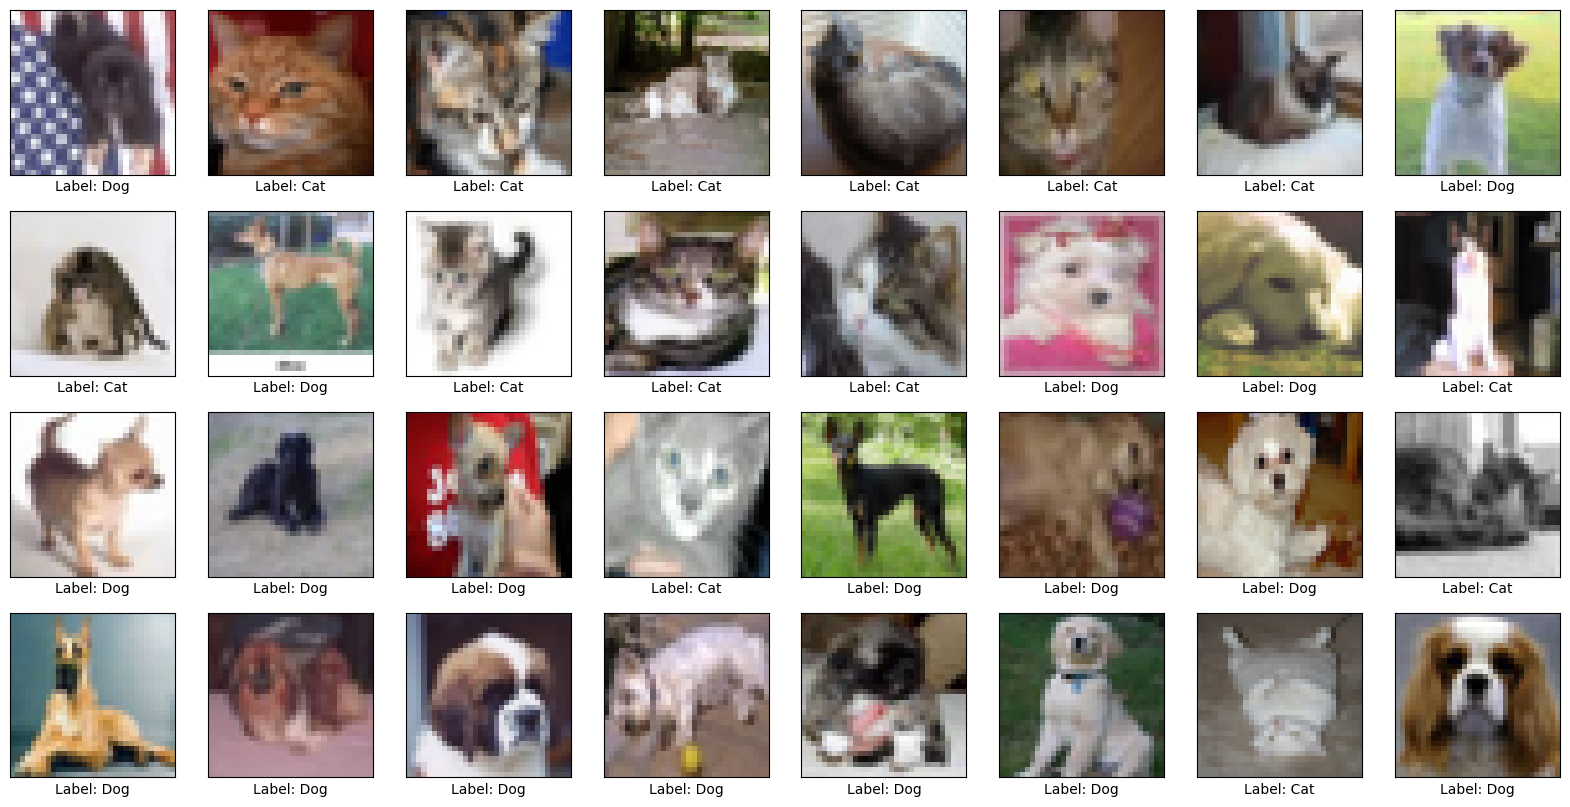

In [40]:
images, labels = next(iter(train_loader))

images = images[:32].numpy()
images = np.transpose(images, (0, 2, 3, 1)) #Channel to the last
label_mappings  = {
    0: "Cat",
    1: "Dog"
}
plt.figure(figsize = (20, 10))
for i in range(len(images)):
  plt.subplot(4, 8, i + 1)
  plt.imshow(images[i])
  plt.xlabel(f"Label: {label_mappings[labels[i].item()]}")
  plt.xticks([])
  plt.yticks([])
plt.show()
#Visualizing the first batch of the images

In [41]:
import torch
from torch import nn

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


In [42]:
from torch.nn.modules import activation
from torchsummary import summary
#Defining the model

class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.ConV_stack = nn.Sequential(

        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        nn.Conv2d(in_channels = 64, out_channels=128, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1),
        nn.ReLU(),

        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),

        nn.Linear(512, 1),
        nn.Sigmoid()
    )

  def forward(self, X):
    Y = self.ConV_stack(X)
    return Y

In [43]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
model = NeuralNetwork().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 4, 4]         295,168
             ReLU-11            [-1, 256, 4, 4]               0
        MaxPool2d-12            [-1, 256, 2, 2]               0
           Conv2d-13            [-1, 512, 2, 2]       1,180,160
             ReLU-14            [-1, 51

In [44]:
#Defining the optimizer and the loss function for the model
optimizer = torch.optim.RMSprop(model.parameters(), lr = 1e-3)
criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience=5)

In [45]:
#Defining the training function
from tqdm import tqdm

def train(dataloader, model, optimizer, loss_fn):
  num_batches = len(dataloader)

  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  pbar = tqdm(dataloader, desc = "Training", leave = True)

  for (X, y) in pbar:
    X, y = X.to(device), y.to(device).float().unsqueeze(1)

    y_pred = model.forward(X)
    loss = loss_fn(y_pred, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    running_loss += loss.item()
    pred = (y_pred > 0.5).float()
    correct += (pred == y).sum().item()
    total += X.size(0)

    pbar.set_postfix(
          loss = f"{(running_loss/(total / X.size(0)))}",
          accuracy = f"{correct/total}"
    )

  train_loss = running_loss / num_batches
  accuracy = correct / total

  return train_loss, accuracy

In [46]:
#Define func for Validation and Test
from tqdm import tqdm

def infer(dataloader, model, loss_fn):
  num_batches = len(dataloader)

  inference_loss = 0.0
  inference_accuracy = 0.0
  total = 0

  model.eval()

  with torch.no_grad():

   pbar = tqdm(dataloader, desc = "Validation", leave = True)

   for X, y in pbar:
      X, y = X.to(device), y.to(device).float().unsqueeze(1)

      y_pred = model.forward(X)
      loss = loss_fn(y_pred, y)

      inference_loss += loss.item()
      predicted = (y_pred > 0.5).float()
      correct = (predicted == y).sum().item()

      inference_accuracy += correct
      total += X.size(0)

      pbar.set_postfix(
          loss = f"{(inference_loss/(total / X.size(0)))}",
          accuracy = f"{inference_accuracy/total}"
      )

  inference_loss /= num_batches
  inference_accuracy /= total

  return inference_loss, inference_accuracy

In [47]:
#Let's train, validate and test with model checkpoint
from tqdm import tqdm

epochs = 50
best_val_loss = float('inf')
save_path = "best_mode.pth"

history = {
    'train_loss': [],
    'train_acc' : [],
    'val_loss' : [],
    'val_acc': [],
}

for epoch in range(epochs):

    #Training
    train_loss, train_acc = train(train_loader, model, optimizer, criterion)

    #Validation
    val_loss, val_acc = infer(val_loader, model, criterion)
    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    #Model Checkpoint
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model.state_dict(), save_path)
      print(f"Model saved to {save_path} ")

print("Training Complete")

#Testing
test_loss, test_acc = infer(test_loader, model, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {(test_acc * 100):.4f}")

Validation: 100%|██████████| 16/16 [00:00<00:00, 106.82it/s, accuracy=0.501, loss=0.44348184823989867]            


Model saved to best_mode.pth 


Validation: 100%|██████████| 16/16 [00:00<00:00, 130.86it/s, accuracy=0.513, loss=0.44317791938781737]             


Model saved to best_mode.pth 


Validation: 100%|██████████| 16/16 [00:00<00:00, 128.34it/s, accuracy=0.531, loss=0.44109843492507933]            


Model saved to best_mode.pth 


Validation: 100%|██████████| 16/16 [00:00<00:00, 111.11it/s, accuracy=0.558, loss=0.4364189052581787]             


Model saved to best_mode.pth 


Validation: 100%|██████████| 16/16 [00:00<00:00, 128.09it/s, accuracy=0.601, loss=0.4262751388549805]             


Model saved to best_mode.pth 


Validation: 100%|██████████| 16/16 [00:00<00:00, 130.20it/s, accuracy=0.594, loss=0.4250928282737732]             


Model saved to best_mode.pth 


Validation: 100%|██████████| 16/16 [00:00<00:00, 121.85it/s, accuracy=0.626, loss=0.4119732093811035]             


Model saved to best_mode.pth 


Validation: 100%|██████████| 16/16 [00:00<00:00, 131.44it/s, accuracy=0.66, loss=0.39813843727111814]             


Model saved to best_mode.pth 


Validation: 100%|██████████| 16/16 [00:00<00:00, 119.44it/s, accuracy=0.694, loss=0.4741075873374939]             


Training Complete


Validation: 100%|██████████| 32/32 [00:00<00:00, 120.57it/s, accuracy=0.713, loss=0.1802933988571167]             

Test Loss: 0.7043
Test Accuracy: 71.3000


C:\Users\nissa\AppData\Local\Temp\ipykernel_27580\2812991459.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


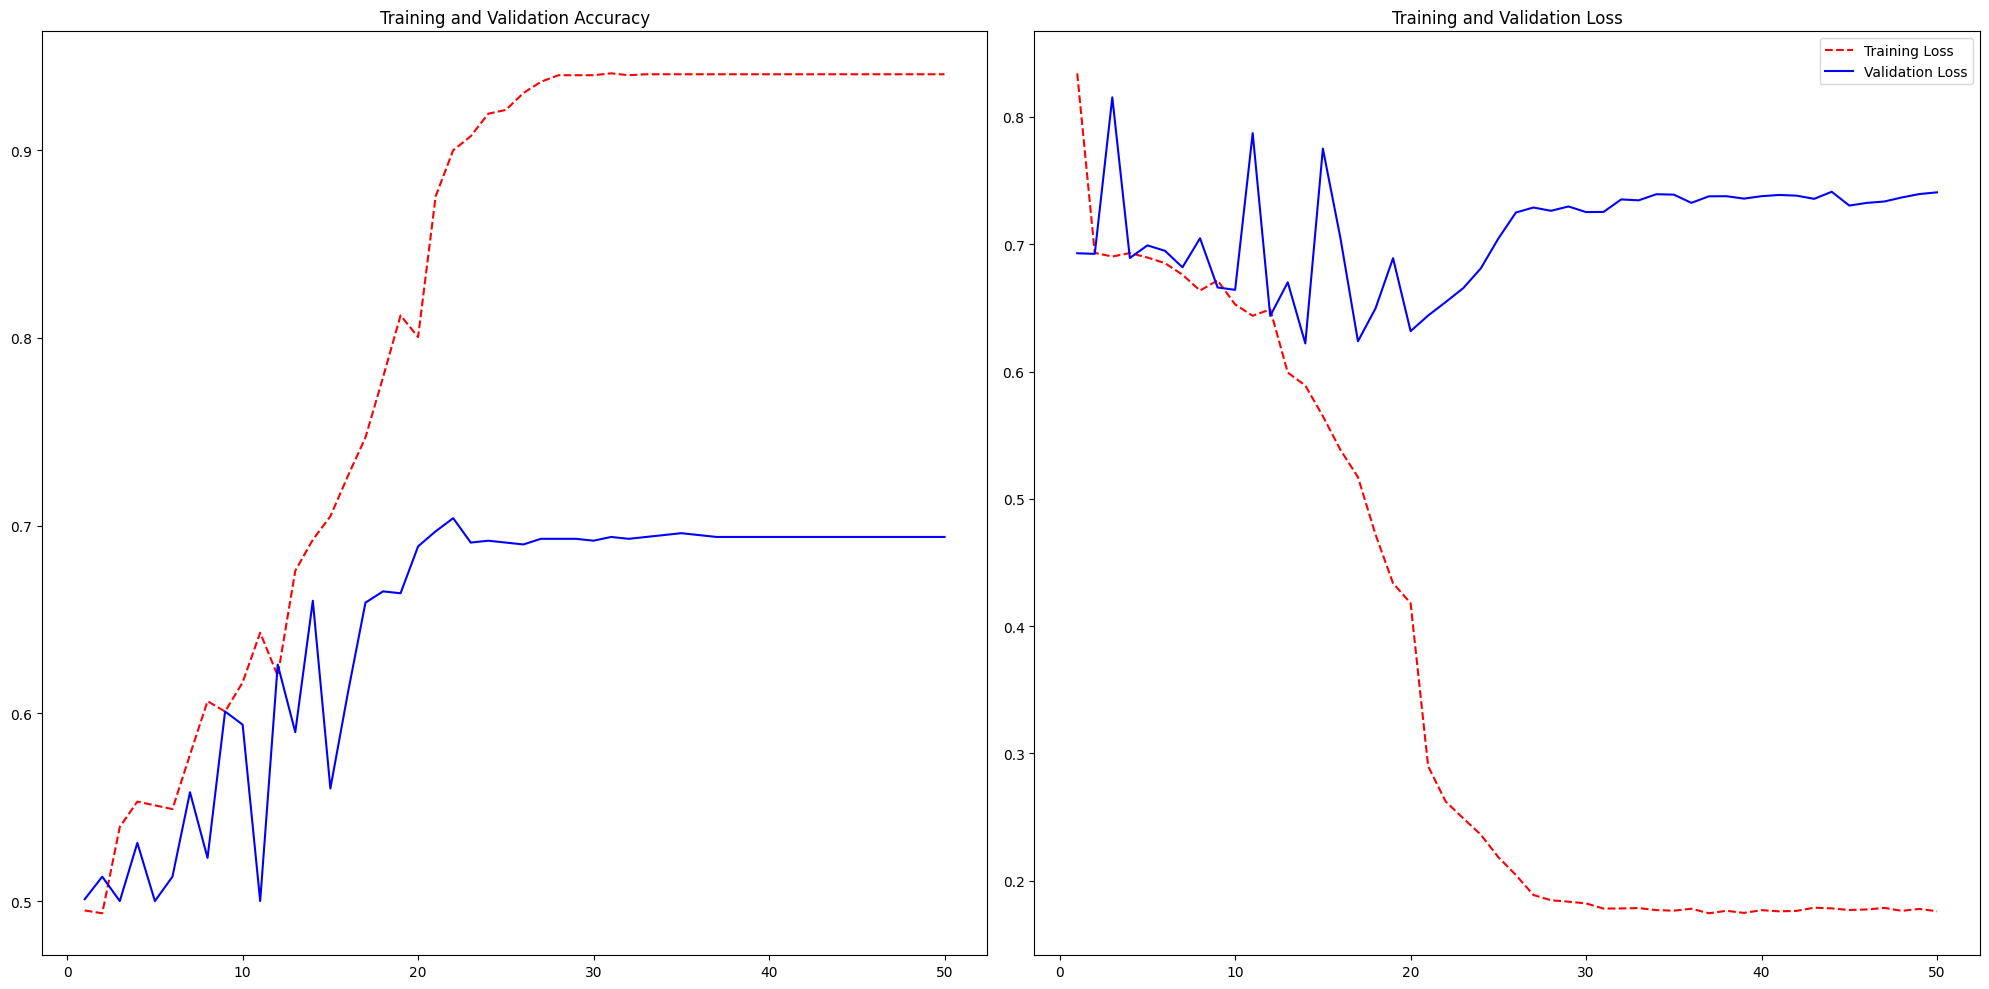

In [48]:
import matplotlib.pyplot as plt

accuracy = history['train_acc']
val_accuracy = history['val_acc']
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(1, 2, figsize = (20, 10))

axes[0].plot(epochs, accuracy, 'r--', label = "Training Accuracy")
axes[0].plot(epochs, val_accuracy, 'b', label = "Validation Accuracy")
axes[0].set_title("Training and Validation Accuracy")
plt.legend()

axes[1].plot(epochs, loss, 'r--', label = "Training Loss")
axes[1].plot(epochs, val_loss, 'b', label = "Validation Loss")
axes[1].set_title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

Predicted tensor([1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 0., 0., 1., 1., 0.])


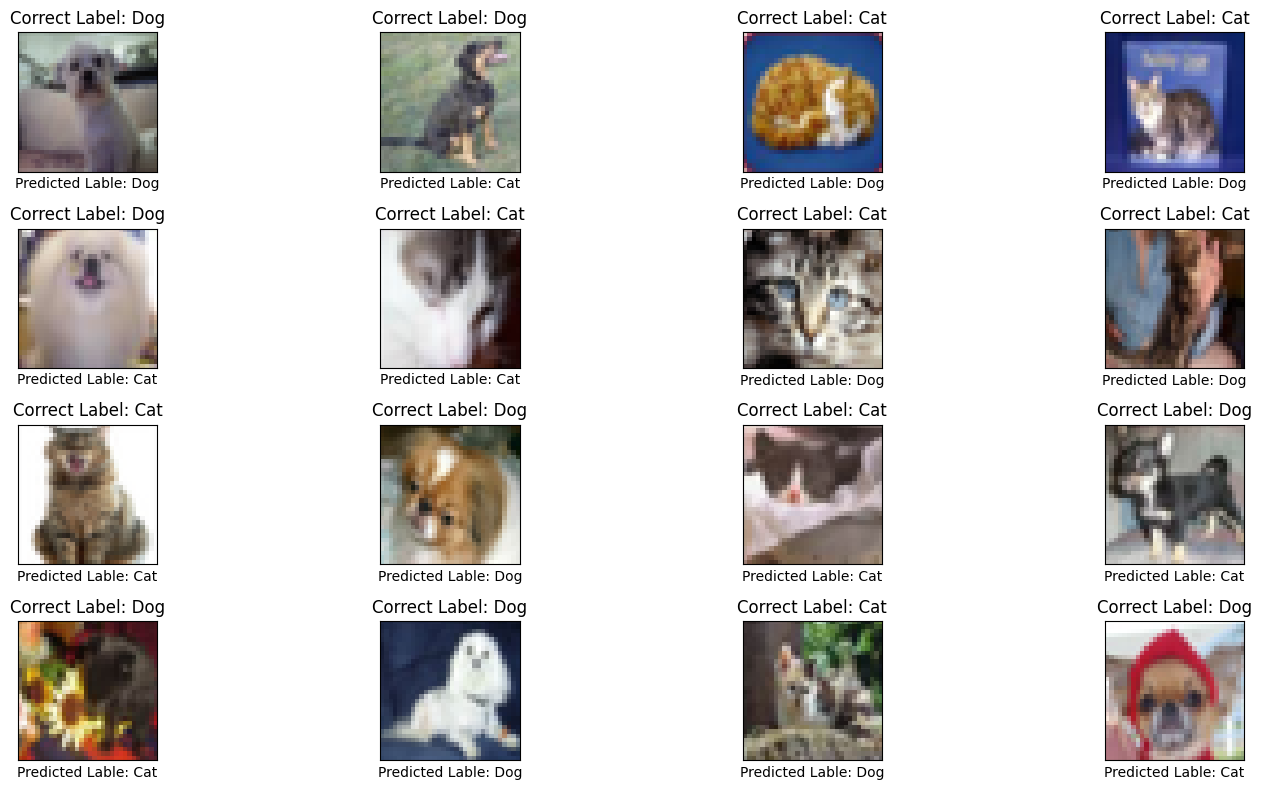

In [49]:
#Visualize sample predictions

best_model = NeuralNetwork()
best_model.load_state_dict(torch.load('best_mode.pth'))

best_model.eval()
images, label = next(iter(test_loader))

image = images[0].to(device)
with torch.no_grad():
  pred = best_model(images)
  predicted = (pred > 0.5).float().cpu().squeeze()

print(f"Predicted {predicted}")

label_map = {
    0: "Cat",
    1: "Dog"
}
images = images.cpu().numpy()
images = np.transpose(images, (0, 2, 3, 1))

plt.figure(figsize=(16, 8))
for i in range(16):
  plt.subplot(4,4, i + 1)
  image = images[i]
  plt.imshow(image)
  plt.title(f"Correct Label: {label_map[label[i].item()]}")
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(f"Predicted Lable: {label_map[predicted[i].item()]}")

plt.tight_layout()
plt.show()

Since this just gave the accuracy of about 70 %, we are going to use the data augmentation technique


In [50]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.ToPILImage(), #Since the input is Tensor as we transformed in the top
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast = 0.2),
    transforms.ToTensor()
])

augmented_train_ready = DatasetWrapper(train_data, transform=train_transform)

In [51]:
#Visualizing the Data Augmentation
batch_size = 64
train_loader = DataLoader(
    augmented_train_ready,
    batch_size, 
    shuffle = True, 
    num_workers=0,
    pin_memory=True
)


In [52]:
images, labels = next(iter(train_loader))
images = np.transpose(images, (0, 2, 3, 1))

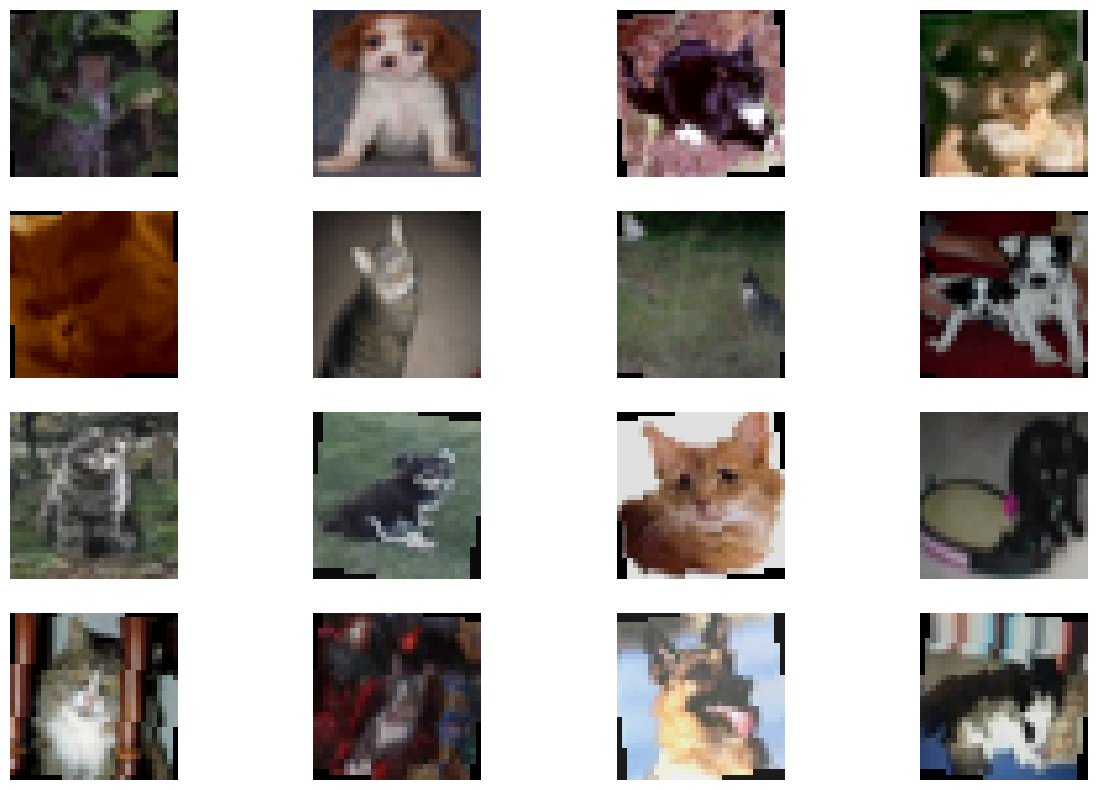

In [53]:

plt.figure(figsize =(15, 10))
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(images[i])
    plt.axis('off')

plt.show()

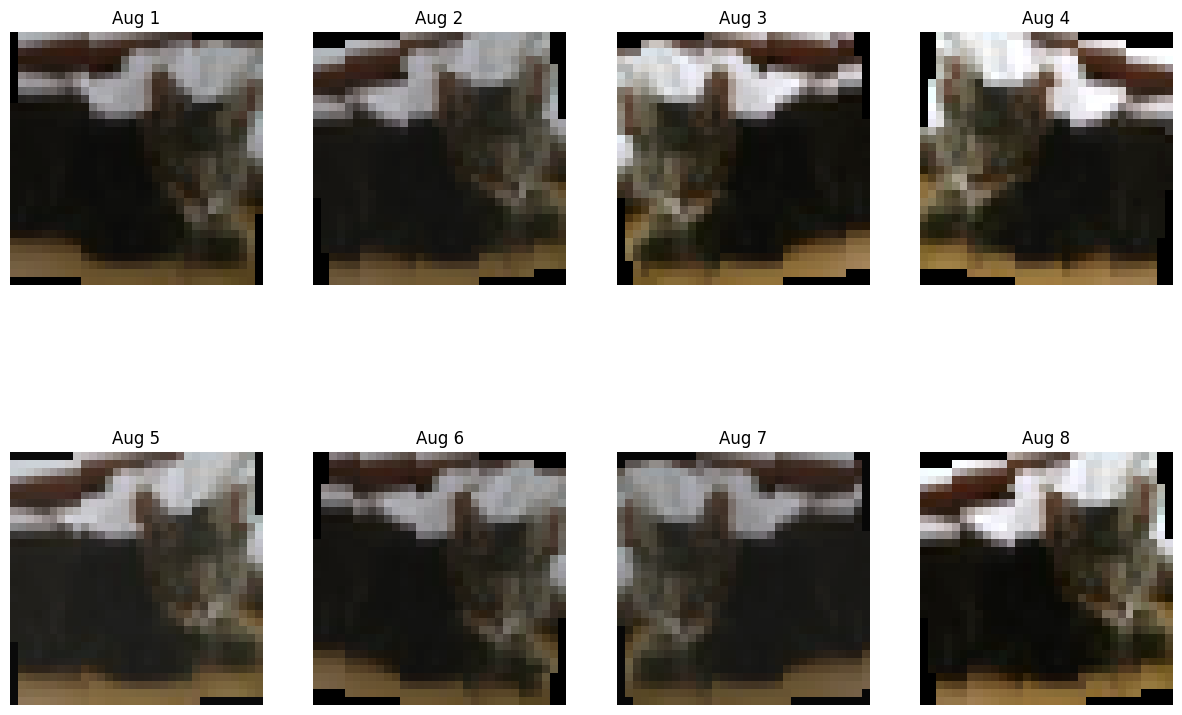

In [54]:
#Visualization of the Data Augmentation
img = images[0]

plt.figure(figsize = (15, 10))

for i in range(8):
    plt.subplot(2, 4, i+1)
    aug_image, label = augmented_train_ready[0]

    aug_image = aug_image.permute(1, 2, 0).numpy()

    plt.subplot(2, 4, i +1)
    plt.imshow(aug_image)
    plt.title(f"Aug {i+1}")
    plt.axis('off')
plt.show()

In [60]:
from torch.nn.modules import activation
from torchsummary import summary

# Defining the model


class AugNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.ConV_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, X):
        Y = self.ConV_stack(X)
        return Y

In [61]:
model = AugNN().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 4, 4]         295,168
             ReLU-11            [-1, 256, 4, 4]               0
        MaxPool2d-12            [-1, 256, 2, 2]               0
           Conv2d-13            [-1, 512, 2, 2]       1,180,160
             ReLU-14            [-1, 51

In [ ]:
# Defining the optimizer and the loss function for the model
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=5
)


In [63]:
# Training, Validating and Testing
from tqdm import tqdm

epochs = 50
best_val_loss = float("inf")
save_path = "best_mode.pth"

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(epochs):

    # Training
    train_loss, train_acc = train(train_loader, model, optimizer, criterion)

    # Validation
    val_loss, val_acc = infer(val_loader, model, criterion)
    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # Model Checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path} ")

print("Training Complete")

# Testing
test_loss, test_acc = infer(test_loader, model, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {(test_acc * 100):.4f}")

Validation: 100%|██████████| 16/16 [00:00<00:00, 135.16it/s, accuracy=0.5, loss=32.0]                            


Model saved to best_mode.pth 


Validation: 100%|██████████| 16/16 [00:00<00:00, 111.81it/s, accuracy=0.5, loss=31.8875]                           


Model saved to best_mode.pth 


Validation: 100%|██████████| 16/16 [00:00<00:00, 69.37it/s, accuracy=0.5, loss=31.8125]                          


Model saved to best_mode.pth 


Training:  31%|███▏      | 10/32 [00:00<00:00, 26.22it/s, accuracy=0.5234375, loss=47.65625]                  


KeyboardInterrupt: 

C:\Users\nissa\AppData\Local\Temp\ipykernel_27580\3111941546.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


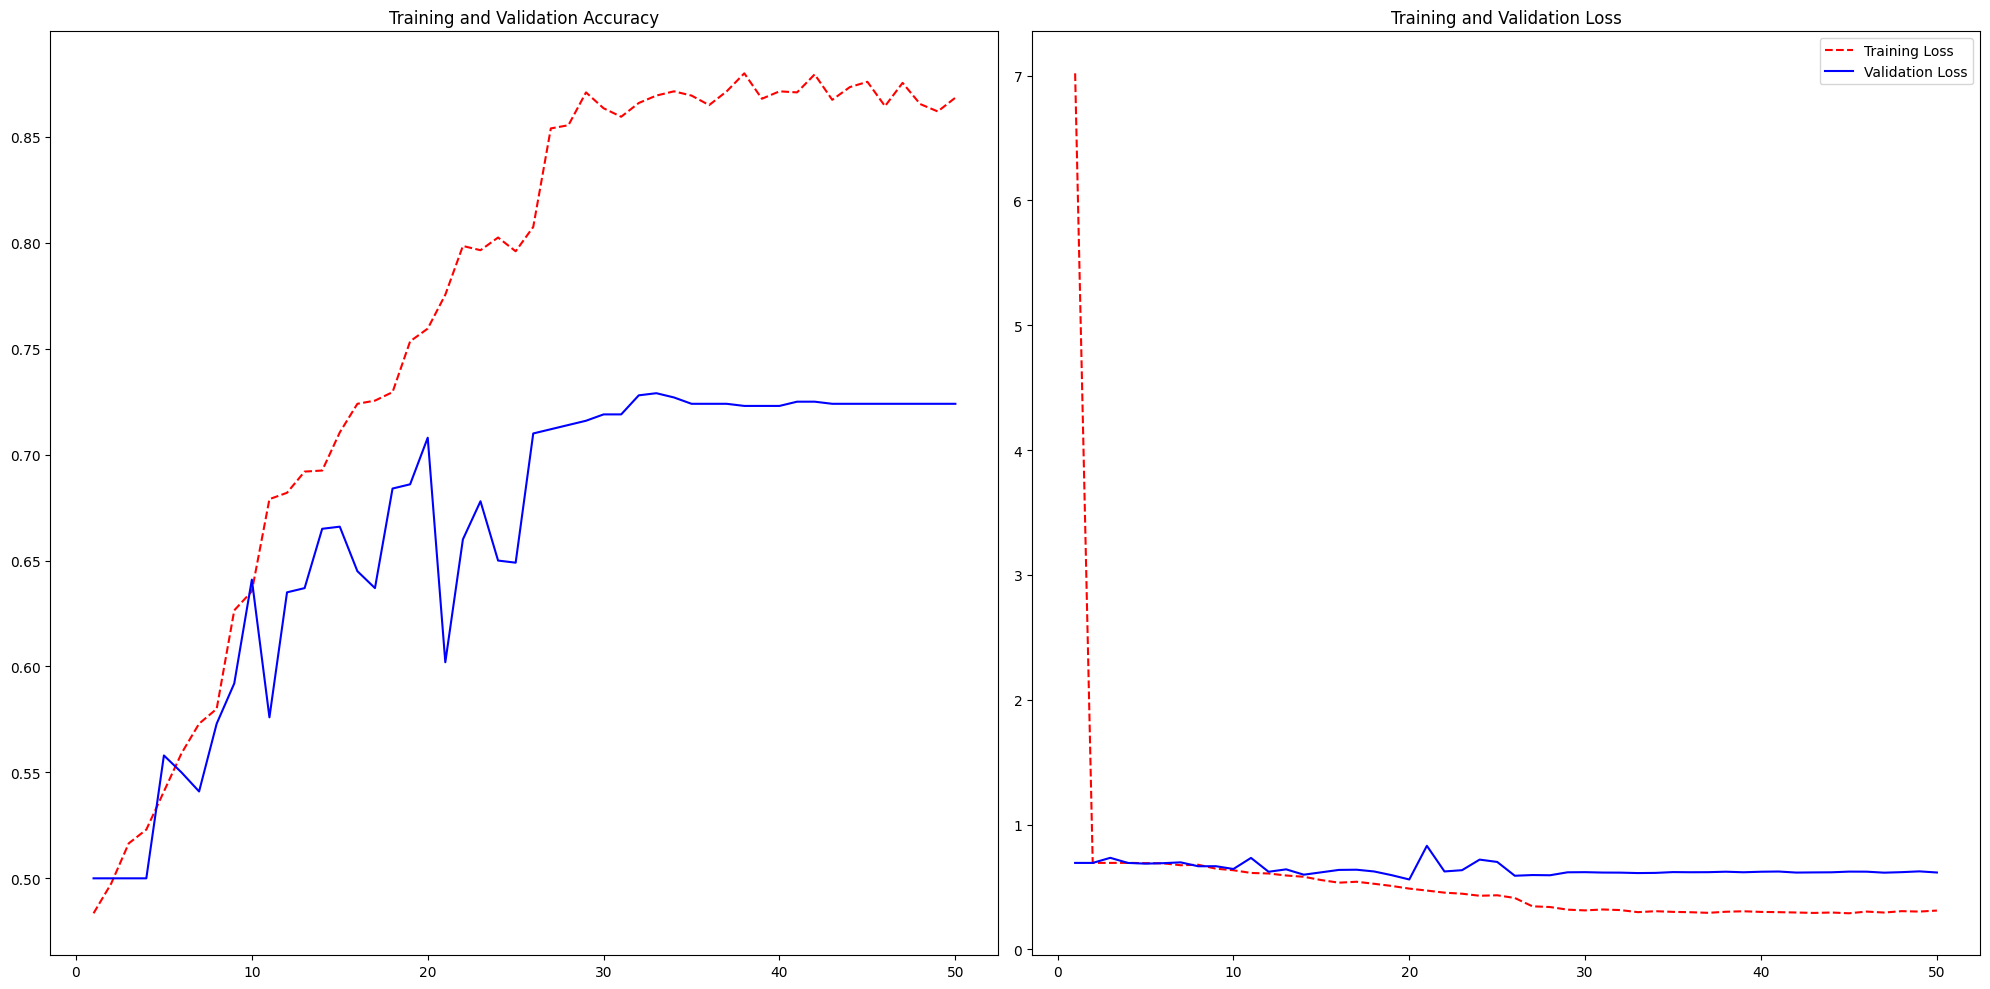

In [59]:
import matplotlib.pyplot as plt

accuracy = history["train_acc"]
val_accuracy = history["val_acc"]
loss = history["train_loss"]
val_loss = history["val_loss"]
epochs = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].plot(epochs, accuracy, "r--", label="Training Accuracy")
axes[0].plot(epochs, val_accuracy, "b", label="Validation Accuracy")
axes[0].set_title("Training and Validation Accuracy")
plt.legend()

axes[1].plot(epochs, loss, "r--", label="Training Loss")
axes[1].plot(epochs, val_loss, "b", label="Validation Loss")
axes[1].set_title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()